0.022358417510986328
Animation completed and saved as rrt_star_animation.gif .


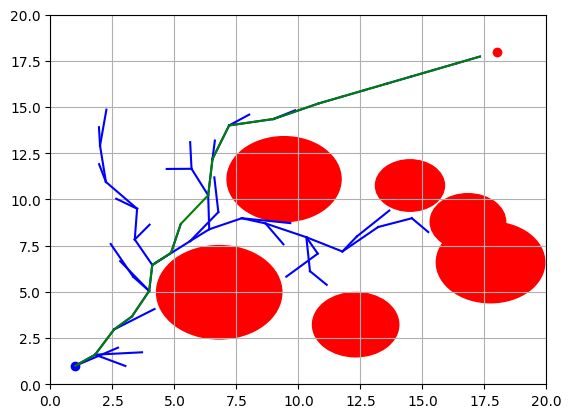

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import random

# Node class representing a state in the space
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0

# RRT* algorithm
class RRTStar:
    def __init__(self, start, goal, num_obstacles, map_size, step_size=1.0, max_iter=500):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.map_size = map_size
        self.obstacles = self.generate_random_obstacles(num_obstacles)
        self.step_size = step_size
        self.max_iter = max_iter
        self.node_list = [self.start]
        self.goal_region_radius = 1.5
        self.search_radius = 2.0
        self.path = None
        self.goal_reached = False

        # Visualization setup
        self.fig, self.ax = plt.subplots()
        self.setup_visualization()

    def generate_random_obstacles(self, num_obstacles):
        """Randomly generate obstacles with random positions and sizes."""
        obstacles = []
        for _ in range(num_obstacles):
            ox = random.uniform(2, self.map_size[0] - 2)
            oy = random.uniform(2, self.map_size[1] - 2)
            size = random.uniform(1, 3)
            obstacles.append((ox, oy, size))
        return obstacles

    def setup_visualization(self):
        """Set up the visualization environment (grid, start, goal, obstacles)."""
        self.ax.plot(self.start.x, self.start.y, 'bo', label='Start')
        self.ax.plot(self.goal.x, self.goal.y, 'ro', label='Goal')
        self.ax.set_xlim(0, self.map_size[0])
        self.ax.set_ylim(0, self.map_size[1])
        self.ax.grid(True)

        # Draw the randomly generated obstacles
        self.draw_obstacles()

    def draw_obstacles(self):
        """Draw the static obstacles on the map."""
        for (ox, oy, size) in self.obstacles:
            circle = plt.Circle((ox, oy), size, color='r')
            self.ax.add_artist(circle)

    def plan(self):
        """Main RRT* planning loop."""
        for i in range(self.max_iter):
            rand_node = self.get_random_node()
            nearest_node = self.get_nearest_node(self.node_list, rand_node)
            new_node = self.steer(nearest_node, rand_node)

            if self.is_collision_free(new_node):
                neighbors = self.find_neighbors(new_node)
                new_node = self.choose_parent(neighbors, nearest_node, new_node)
                self.node_list.append(new_node)
                self.rewire(new_node, neighbors)

            if self.reached_goal(new_node):
                self.path = self.generate_final_path(new_node)
                self.goal_reached = True
                return

    def get_random_node(self):
        """Generate a random node in the map."""
        if random.random() > 0.2:
            rand_node = Node(random.uniform(0, self.map_size[0]), random.uniform(0, self.map_size[1]))
        else:
            rand_node = Node(self.goal.x, self.goal.y)
        return rand_node

    def steer(self, from_node, to_node):
        """Steer from one node to another, step-by-step."""
        theta = math.atan2(to_node.y - from_node.y, to_node.x - from_node.x)
        new_node = Node(from_node.x + self.step_size * math.cos(theta),
                        from_node.y + self.step_size * math.sin(theta))
        new_node.cost = from_node.cost + self.step_size
        new_node.parent = from_node
        return new_node

    def is_collision_free(self, node):
        """Check if the node is collision-free with respect to obstacles."""
        for (ox, oy, size) in self.obstacles:
            if (node.x - ox) ** 2 + (node.y - oy) ** 2 <= size ** 2:
                return False
        return True

    def find_neighbors(self, new_node):
        """Find nearby nodes within the search radius."""
        return [node for node in self.node_list
                if np.linalg.norm([node.x - new_node.x, node.y - new_node.y]) < self.search_radius]

    def choose_parent(self, neighbors, nearest_node, new_node):
        """Choose the best parent for the new node based on cost."""
        min_cost = nearest_node.cost + np.linalg.norm([new_node.x - nearest_node.x, new_node.y - nearest_node.y])
        best_node = nearest_node

        for neighbor in neighbors:
            cost = neighbor.cost + np.linalg.norm([new_node.x - neighbor.x, new_node.y - neighbor.y])
            if cost < min_cost and self.is_collision_free(neighbor):
                best_node = neighbor
                min_cost = cost

        new_node.cost = min_cost
        new_node.parent = best_node
        return new_node

    def rewire(self, new_node, neighbors):
        """Rewire the tree by checking if any neighbor should adopt the new node as a parent."""
        for neighbor in neighbors:
            cost = new_node.cost + np.linalg.norm([neighbor.x - new_node.x, neighbor.y - new_node.y])
            if cost < neighbor.cost and self.is_collision_free(neighbor):
                neighbor.parent = new_node
                neighbor.cost = cost

    def reached_goal(self, node):
        """Check if the goal has been reached."""
        return np.linalg.norm([node.x - self.goal.x, node.y - self.goal.y]) < self.goal_region_radius

    def generate_final_path(self, goal_node):
        """Generate the final path from the start to the goal."""
        path = []
        node = goal_node
        while node is not None:
            path.append([node.x, node.y])
            node = node.parent
        return path[::-1]  # Reverse the path

    def get_nearest_node(self, node_list, rand_node):
        """Find the nearest node in the tree to the random node."""
        distances = [np.linalg.norm([node.x - rand_node.x, node.y - rand_node.y]) for node in node_list]
        nearest_node = node_list[np.argmin(distances)]
        return nearest_node

    def draw_tree(self, node):
        """Draw a tree edge from the current node to its parent."""
        if node.parent:
            self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], "-b")

    def draw_path(self):
        """Draw the final path from start to goal."""
        if self.path:
            self.ax.plot([x[0] for x in self.path], [x[1] for x in self.path], '-g', label='Path')

# Animation function to run the RRT* iterations and plot in real-time
def animate(i):
    if i < rrt_star.max_iter and not rrt_star.goal_reached:
        rand_node = rrt_star.get_random_node()
        nearest_node = rrt_star.get_nearest_node(rrt_star.node_list, rand_node)
        new_node = rrt_star.steer(nearest_node, rand_node)

        if rrt_star.is_collision_free(new_node):
            neighbors = rrt_star.find_neighbors(new_node)
            new_node = rrt_star.choose_parent(neighbors, nearest_node, new_node)
            rrt_star.node_list.append(new_node)
            rrt_star.rewire(new_node, neighbors)
            rrt_star.draw_tree(new_node)

        if rrt_star.reached_goal(new_node):
            rrt_star.path = rrt_star.generate_final_path(new_node)
            rrt_star.draw_path()
            rrt_star.goal_reached = True  # Set the goal reached flag

# Main execution
if __name__ == "__main__":
    start = [1, 1]
    goal = [18, 18]
    num_obstacles = 6  # Number of random obstacles
    map_size = [20, 20]
    t1 = time.time()
    rrt_star = RRTStar(start, goal, num_obstacles, map_size)

    # Create animation
    ani = animation.FuncAnimation(rrt_star.fig, animate, frames=rrt_star.max_iter, interval=10, repeat=False)
    res = time.time() - t1
    print(res)
    with open("./resultados", "a") as f:
        f.write(
            f"Tiempo: {res}\n"
        )
    # Save the animation
    filename='rrt_star_animation.gif'
    ani.save(filename=filename, writer='pillow', fps=30)

    print(f"Animation completed and saved as {filename} .")